In [1]:
from random import choices
from sage.all import *
from sage.rings.number_field.number_field import CyclotomicField
from sage.rings.integer_ring import ZZ
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def recover_sparse_cyclotomic(p: int, l: int, Mscale=10 ** 6, Nscale=20, obj_dims=1, noise=False) -> tuple[list[int], Matrix]:
    """For a randomly generated cyclotomic integer `z` summed from `l` `p`^th roots of unity,
    generates LLL (short, nearly orthogonal) basis vectors to approximate `z`. \n

    Each basis vector `vec` consists of:
    - `vec`[0:2] corresponding to the Re and Im parts of the objective value
    - `vec`[2:p+2] corresponding to the coefficients for each root of unity
    - `vec`[p+2:p+2+obj_dims] corresponding to the coefficients for Re and Im parts of target value

    ### Parameters:
    - `p`: order of root of unity (must be prime).
    - `l`: number of nonzero integer terms in cyclotomic integer decomposition.
    - `Mscale`: lattice scaling factor for objective complex values.
    - `Nscale`: lattice scaling factor for integer mapping.
    - `obj_dims`: number of dimensions assigned to target value (1 or 2).
    - `noise`: include Gaussian noise of scale Nscale/Mscale in input cyclotomic integer.

    ### Returns:
    - `exp`: exponents of roots of unity used to generate z.
    - `lll_mat`: List of candidate basis vectors as output of LLL algorithm.
    """
    if not is_prime(p):
        raise ValueError("p must be prime")
    
    if not (obj_dims == 1 or obj_dims == 2):
        raise ValueError("obj_dims must be 1 or 2")

    # Initialize cyclotomic field
    K = CyclotomicField(p)
    zeta = K.gen()

    # Generate random cyclotomic integer
    X = [0]*p
    exps = choices(range(p), k=l)
    for i in exps:
        X[i] += 1
    z = sum(X[i] * zeta**i for i in range(p))
    if noise:
        z += np.random.normal(scale=Nscale/Mscale) + 1j * np.random.normal(scale=Nscale/Mscale)

    # Construct the lattice basis matrix
    B = Matrix(ZZ, p + obj_dims, p + obj_dims + 2)

    # Set first row to real parts
    zeta_re = [CC(zeta**i).real() for i in range(p)]
    for i in range(p):
        B[i, 0] = int(round(zeta_re[i] * Mscale))
    B[p, 0] = -1 * int(round(CC(z).real() * Mscale))  # target real part

    # Set second row to imaginary parts
    zeta_im = [CC(zeta**i).imag() for i in range(p)]
    for i in range(p):
        B[i, 1] = int(round(zeta_im[i] * Mscale))
    B[p + obj_dims - 1, 1] = -1 * int(round(CC(z).imag() * Mscale))  # target imag part

    # Scaled identity matrix
    for i in range(p):
        B[i, 2 + i] = Nscale
    B[p, p+2] = 1
    if obj_dims == 2:
        B[p+1, p+3] = 1

    B_lll = B.LLL()
    return exps, B_lll


def filter_candidate(vec: list, l: int, Nscale: int, obj_dims: int) -> bool:
    """Check whether candidate vector satisfies constraints of 
    the cyclotomic integer decomposition integer relation problem.
    - `abs(vec)[0:-obj_dims]` sums to `l`.
    - `abs(vec)[-obj_dims:]` indicates one multiple of the target value is included in basis vector.

    ### Parameters:
    - `vec`: vector to evaluate, from `recover_sparse_cyclotomic`.
    - `l`: number of expected nonzero integer terms.
    - `Nscale`: lattice scaling factor for integer mapping.
    - `obj_dims`: number of dimensions assigned to objective value (1 or 2).

    ### Returns:
    - boolean indicating whether `vec` satisfies the following:
    \t - `vec[0:-obj_dims]` has 1-norm `l * Nscale`.
    \t - `vec[-obj_dims:]` indicates one multiple of the target value is included in basis vector.
    """
    
    # Check for sum of integer entries
    if obj_dims == 1:
        if (vec[-1] == 1 and np.all(vec >= 0)) or (vec[-1] == -1 and np.all(vec <= 0)):
            return np.sum(vec[:-1]) == l * Nscale * vec[-1]
    
    if obj_dims == 2:
        if (vec[-2] == 1 and vec[-1] == 1 and np.all(vec >= 0)) or (vec[-2] == -1 and vec[-1] == -1 and np.all(vec <= 0)):
            return np.sum(vec[:-2]) == l * Nscale * vec[-1]
    
    return False


def run_trials(primes, l, Mscale, Nscale, obj_dims, num_trials, noise):
    # Generate placeholder to record correct trials and time taken for each prime
    results = np.zeros(len(primes))
    times = np.zeros(len(primes))
    init_time = time.time()
    
    for i in range(len(primes)):
        start_time = time.time()
        print(f"Beginning prime {primes[i]} at {start_time - init_time}")
        for j in range(num_trials):
            exps, lll_mat = recover_sparse_cyclotomic(primes[i], l, Mscale=Mscale, Nscale=Nscale, obj_dims=obj_dims, noise=noise)
            bool_arr = np.array([filter_candidate(row[2:], l, Nscale=N, obj_dims=obj_dims) for row in np.array(lll_mat)])
            candidates = np.array(lll_mat)[bool_arr]

            # Match successful candidate vectors
            if candidates.any():
                expected_arr = np.zeros(primes[i])
                for exp in exps:
                    expected_arr[exp] += N
                if not (np.abs(candidates[0][2:-obj_dims]) - expected_arr).any():
                    results[i] += 1
        end_time = time.time()
        times[i] = end_time - start_time
    return results, times


In [28]:
# primes = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
primes = [47]
# primes = [23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
# primes = [73, 79, 83, 89, 97]
l = 17
M = 10 ** 15 # maximum and most effective
N = 20 # decrease for errorless trials
dims = 1
trials = 1000

results, times = run_trials(primes, l, M, N, dims, trials, noise=True)

print(f"Results: {results}")
print(f"Times: {times}")

Beginning prime 47 at 1.430511474609375e-06
Results: [443.]
Times: [87.24665642]


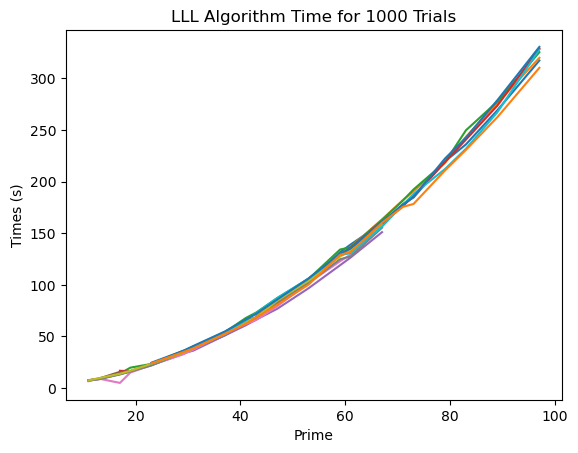

In [20]:
primes1 = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y1 = [7.39, 9.03, 13.57, 16.12, 22.28, 33.12, 37.69, 51.03, 62.22, 68.12, 82.75, 102.83, 131.57, 139.03, 159.72, 178.36, 184.52, 219.53, 235.96, 269.08, 317.2]
primes2 = [43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y2 = [70.57, 83.54, 105.48, 128.69, 136.67, 163.46, 182.18, 190.58, 218.12, 243.28, 276.19, 319.81]
primes3 = [17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y3 = [14.08, 19.81, 23.41, 35.98, 38.23, 54.1, 67.84, 73.2, 87.13, 105.78, 134.18, 136.31, 162.83, 181.77, 192.35, 218.69, 249.65, 277.42, 325.29]
y4 = [16.76, 16.34, 23.5, 35.46, 40.27, 53.13, 65.43, 68.38, 84.14, 105.89, 129.19, 133.91, 159.11, 176.45, 185.99, 218.89, 240.68, 273.58, 328.75]
primes5 = [11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67]
y5 = [7.68, 8.55, 13.71, 16.28, 22.88, 33.63, 36.28, 51.04, 60.79, 66.36, 76.79, 96.77, 119.01, 126.43, 151.02]
y6 = [7.6, 9.27, 15.74, 16.44, 22.61, 34.04, 38.88, 52.53, 64.36, 68.41, 81.93, 104.66, 128.65, 136.04, 161.69]
y7 = [6.69, 9.2	, 5.02, 15.09, 22.28, 32.57, 37.28, 53.33, 62.09, 65.99, 79.3, 101.91, 122.87, 129.3, 158.48]
y8 = [7.26, 8.65, 13.2, 16.09, 21.85, 34.56, 38.6, 52.81, 64.07, 68.83, 83.43, 101.96, 124.82, 127.44, 155.34]
y9 = [7.5, 9.62, 13.91, 16.83, 23.56, 34.13, 38.78, 52.3, 64.21, 68.49, 84.68, 104.02, 127.4, 133.18, 157.4]
primes10 = [23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
y10 = [23.92, 35.08, 40.37, 54.3, 65.49, 72.66, 87.27, 106.11, 128.99, 130.59, 156.43, 177.59, 187.93, 212.07, 231.79, 267.18, 327.89]
y11 = [24.59, 35.97, 40.75, 54.77, 66.35, 71.99, 85.75, 106.26, 130.17, 135.28, 161.2, 177.51, 185.21, 222.26, 242.55, 278.79, 330.36]
y12 = [24.01, 34.7, 38.5, 52.59, 62.29, 68.35, 80.7, 100.25, 129.07, 131.77, 160.13, 175.53, 178.31, 210.72, 230.7, 262.39, 310.14]
plt.plot(primes1, y1)
plt.plot(primes2, y2)
plt.plot(primes3, y3)
plt.plot(primes3, y4)
plt.plot(primes5, y5)
plt.plot(primes5, y6)
plt.plot(primes5, y7)
plt.plot(primes5, y8)
plt.plot(primes5, y9)
plt.plot(primes10, y10)
plt.plot(primes10, y11)
plt.plot(primes10, y12)
plt.title("LLL Algorithm Time for 1000 Trials")
plt.xlabel("Prime")
plt.ylabel("Times (s)")
plt.show()

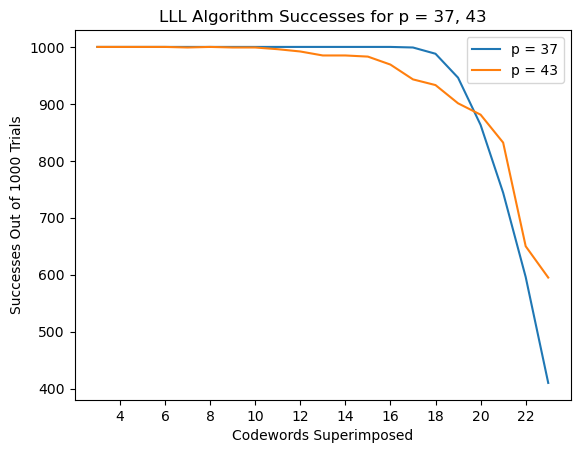

In [30]:
codewords = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
successes37 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 988, 946, 863, 744, 596, 410]
successes43 = [1000, 1000, 1000, 1000, 999, 1000, 999, 999, 996, 992, 985, 985, 983, 969, 943, 933, 901, 881, 832, 650, 595]
plt.plot(codewords, successes37, label='p = 37')
plt.plot(codewords, successes43, label='p = 43')
plt.title("LLL Algorithm Successes for p = 37, 43")
plt.xlabel("Codewords Superimposed")
plt.xticks([4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel("Successes Out of 1000 Trials")
plt.legend()
plt.show()